### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/6_RL_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment 1 line
#!pip install stable_baselines==2.9.0

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# baselines framework
see code:
- https://github.com/openai/baselines
- https://github.com/hill-a/stable-baselines

And doc:
- https://stable-baselines.readthedocs.io/en/master/index.html

Pre-trained agent:
- https://github.com/araffin/rl-baselines-zoo

### Train, Save, Load (Example DQN): 

In [3]:
import gym

from stable_baselines import DQN
from stable_baselines.common.evaluation import evaluate_policy


# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = DQN('MlpPolicy', env, learning_rate=1e-3, prioritized_replay=True, verbose=1)
# Train the agent
model.learn(total_timesteps=10000)
# Save the agent
model.save("dqn_lunar")
del model  # delete trained model to demonstrate loading


/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/raphael/rl_introduction/venv/lib/python3







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [4]:
# Load the trained agent
model = DQN.load("dqn_lunar")

# Evaluate the agent
mean_reward, n_steps = evaluate_policy(model, env, n_eval_episodes=10)

# Enjoy trained agent
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
env.close()

Loading a model without an environment, this model cannot be trained until it has a valid environment.


### Hyper parameters:

In [5]:
from stable_baselines import DQN, A2C
import tensorflow as tf

#### The policy:

You can use available policies 'MlpPolicy' (fully connected), 'CnnPolicy' (convolutional) and configure them. For example:
- 3 layers of 32, 16, 8 neurons for dqn

In [6]:
policy_kwargs = dict(act_fun=tf.nn.relu, layers=[32, 16, 8])
model = DQN('MlpPolicy', env, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=500)

- 1 share layer of 64 neurons
- 2 specifics layers od 32, 16 neurons for policy model
- 3 specifics layers of 64, 16, 16 neurons for value function model

In [7]:
policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[64, dict(pi=[32, 16],
                                                          vf=[64, 16, 16])])
model = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=500)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Specific parameters of algorithms

For example for DQN:
- buffer_size – (int) size of the replay buffer
- batch_size – (int) size of a batched sampled from replay buffer for training
- double_q – (bool) Whether to enable Double-Q learning or not.
- prioritized_replay – (bool) if True prioritized replay buffer will be used.
- learning_rate – (float) learning rate



In [8]:
model = DQN('MlpPolicy', env,
            learning_rate=0.0005,
            buffer_size=50000,
            batch_size=32,
            double_q=True)
model.learn(total_timesteps=500)

For example for A2C:
- n_steps – (int) The number of steps to run for each environment per update (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
- max_grad_norm – (float) The maximum value for the gradient clipping
- learning_rate – (float) The learning rate

In [9]:
model = A2C('MlpPolicy', env,
            learning_rate=0.0007,
            n_steps=5,
            max_grad_norm=0.5)
model.learn(total_timesteps=500)

### monitoring 

In [10]:
from stable_baselines.bench import Monitor
from stable_baselines import DDPG, DQN
import seaborn as sns
sns.set_style("darkgrid")

In [11]:

from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import PPO2, DQN
# Create log dir
time_steps = 1000
log_dir = "tmp/test"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('CartPole-v0')
env = Monitor(env, log_dir, allow_early_resets=True)

model = DQN('MlpPolicy', env, verbose=0)
time_steps = 5000
model.learn(total_timesteps=time_steps)

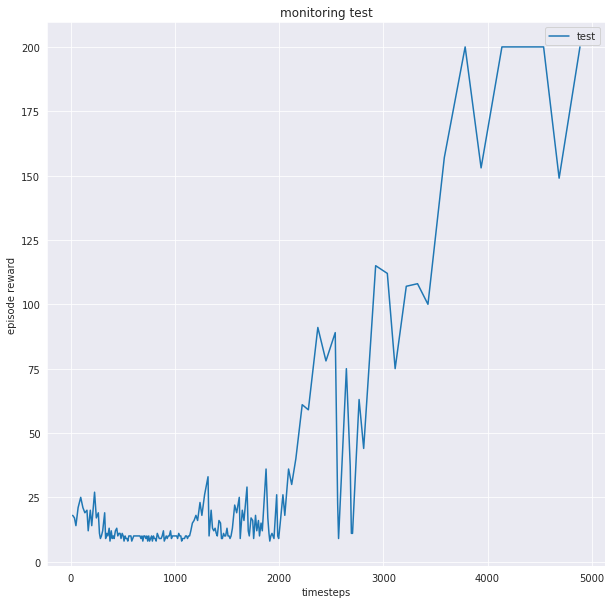

In [12]:
fig,ax = plt.subplots(figsize=(10,10))
res = pd.read_csv(log_dir+'/monitor.csv', skiprows=1)
ax.plot(res['l'].cumsum(), res['r'], label = 'test')
ax.set_xlabel('timesteps')
ax.set_ylabel('episode reward')
ax.set_title('monitoring test')
ax.legend()

### Benchmark

In [13]:
env_names = ['MountainCar-v0','CartPole-v1','LunarLander-v2']
algs = [A2C,DQN]
alg_names = ['a2c','dqn']
layers = [[32],[64,32],[64,32,16]]

In [14]:
time_steps = 100000

In [15]:
for env_name in env_names:
    for i,alg in enumerate(algs):
        print(alg_names[i])
        for l,layer in enumerate(layers):
            tf.reset_default_graph()
            
            log_dir= output_dir='tmp/'+alg_names[i]+'_'+env_name + '_' + str(len(layer))
            os.makedirs(log_dir, exist_ok=True) 
            
            env = gym.make(env_name)
            env = Monitor(env, log_dir, allow_early_resets=True)
            
            if alg_names[i] == 'dqn':
                policy_kwargs = dict(act_fun=tf.nn.relu, layers=layer)
            else:
                policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=layer)
            
            model = alg('MlpPolicy', env, verbose=0, policy_kwargs=policy_kwargs)

            model.learn(total_timesteps=time_steps)# , callback=callback)

a2c
dqn
a2c
dqn
a2c
dqn


a2c
dqn
a2c
dqn
a2c
dqn


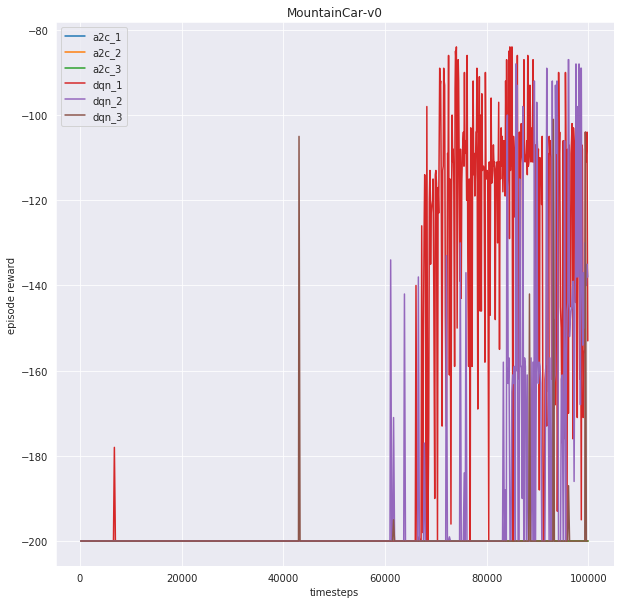

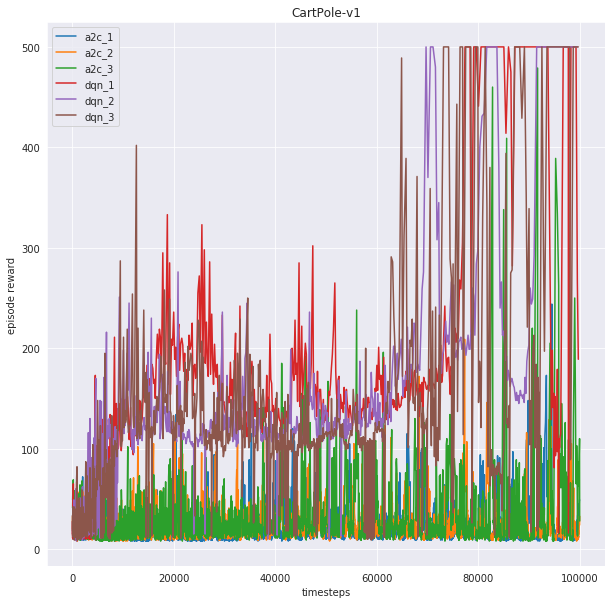

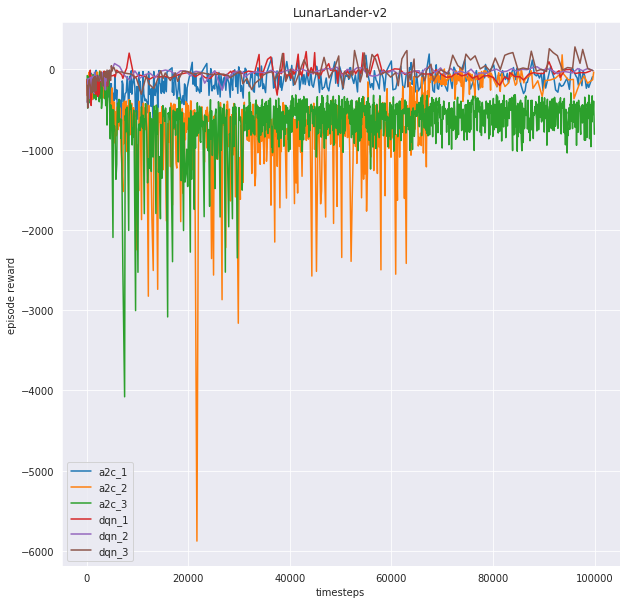

In [16]:
glob_res = {}
for env_name in env_names:
    fig,ax = plt.subplots(figsize=(10,10))
    glob_res['env_name'] = {}
    for i,alg in enumerate(algs):
        glob_res['env_name'][alg_names[i]] = {}
        print(alg_names[i])
        for l,layer in enumerate(layers):
            tf.reset_default_graph()

            log_dir= output_dir='tmp/'+alg_names[i]+'_'+env_name + '_' + str(len(layer))
            res = pd.read_csv(log_dir+'/monitor.csv', skiprows=1)
            ax.plot(res['l'].cumsum(), res['r'], label = alg_names[i]+ '_' + str(len(layer)))
            
            glob_res['env_name'][alg_names[i]][str(len(layer))] = res
    ax.set_xlabel('timesteps')
    ax.set_ylabel('episode reward')
    ax.set_title(env_name)
    ax.legend()

### More complete benchmark dor doing better!

DQN parameter
https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb

atari baselines scores https://github.com/araffin/rl-baselines-zoo/blob/master/benchmark.md

atari spinningup scores https://spinningup.openai.com/en/latest/spinningup/bench.html

compute other metrics https://github.com/deepmind/bsuite

### Example of train with atari

In [17]:
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines import A2C

# There already exists an environment generator
# that will make and wrap atari environments correctly.
# Here we are also multiprocessing training (num_env=4 => 4 processes)
env = make_atari_env('PongNoFrameskip-v4', num_env=4, seed=0)
# Frame-stacking with 4 frames
env = VecFrameStack(env, n_stack=4)

model = A2C('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=25000)

---------------------------------
| explained_variance | -123     |
| fps                | 62       |
| nupdates           | 1        |
| policy_entropy     | 1.79     |
| total_timesteps    | 20       |
| value_loss         | 0.00664  |
---------------------------------
---------------------------------
| explained_variance | -1.97    |
| fps                | 301      |
| nupdates           | 100      |
| policy_entropy     | 1.79     |
| total_timesteps    | 2000     |
| value_loss         | 0.000649 |
---------------------------------
---------------------------------
| ep_len_mean        | 838      |
| ep_reward_mean     | -21      |
| explained_variance | -1.76    |
| fps                | 306      |
| nupdates           | 200      |
| policy_entropy     | 1.79     |
| total_timesteps    | 4000     |
| value_loss         | 0.000726 |
---------------------------------
---------------------------------
| ep_len_mean        | 884      |
| ep_reward_mean     | -20.5    |
| explained_va